# GPU : Fine-tuning a Transformer based Model - distilbert-base-uncased

Language modeling is a common method of pretraining on unlabeled text (self supervised learning). Most of the language models learned by iteratively predicting next word in a sequence auto regressively across enormous data sets of text like wikepedia. This can be left to right, right to left or bi-directional. The current state-of-the-art models are based on transformer based architectures such as ChatGPT, LLama, BERT etc. BERT is one of the popular transformer based models that is widely used for performing many downstream NLP tasks. BERT reformulates the language modeling pretrained task of iteratively predicting the next word in sequence to instead incorporate bidirectional context and predict mask of intermediate tokens of the sequence and predict the mask token. BERT presented a new self supervised learning task for pretaining transformers inorder to fine tune them for different tasks. They major difference between BERT and prior methods of pretraining transformer models is using the bidirectional context of language modeling. Most of the models either move left to right or right to left to predict next word in sequence, where BERT tries to learn intermediate tokens (by MASK), making the name Bidirectional Encoder.

Ref: <br>

1) http://jalammar.github.io/illustrated-bert/ <br>
2) https://mccormickml.com/2019/07/22/BERT-fine-tuning/ <br>

BERT uses Masked language model and also use "Next sentence prediction" task. BERT uses 3 embeddings to compute the input representations. They are token embeddings, segment embeddings and position embeddings.BERT Transformer will preserve the length of the (dimention of the) input. The final output will take this vector and pass these to seperate tasks (classification, in this case). BERT consists of stacked encoder layers. Just like the input of encoder of the transformer model, BERT model takes the sequence of numeric representation of the tokens as input. For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence. Encoder block of transformer outputs a vector with same length as of input. First position of the vector, corresponding to the [CLS] token, can now be used as the input for a classifier. Models pre-trained on larger data may give good performance for specific tasks when we directly use them. Finetuning is a widely used technique for using a pretrained model for performing a specific task. Finetuning often involves the change of all/many of the model parameters, which may not be inefficient for usecases with low hardware resources. 

In this notebook, we will finetune a BERT based model using a parameter efficient finetuning method called LoRA and compare its performance with normal finetuning. 

# LoRA

Ref : https://arxiv.org/pdf/2106.09685.pdf

LoRA is one of the most widely used parameter efficient finetuning method. Low-Rank Adaptation, or LoRA, which freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture, greatly reducing the number of trainable parameters for downstream tasks. LoRA performs on-par or better than finetuning in model quality Despite having fewer trainable parameters, a higher training throughput, and, unlike adapters,no additional inference latency.

LoRA, which freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture, greatly reducing the number of trainable parameters for downstream task.

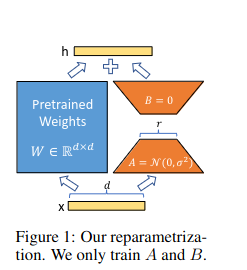

Figure 1 illustrates how LoRA works for a parameter matrix $W$ of $ d * d $. There exist works that shows that the learned over-parametrized models reside on a low intrinsic dimension.The authors of the LoRA hypothesize that the change in weights during model adaptation also has a low “intrinsic rank”. LoRA allows us to train some dense layers in a neural network indirectly by optimizing rank decomposition matrices of the dense layers’ change during adaptation instead, while keeping the pre-trained weights froze.


#### Code Reference

https://lightning.ai/lightning-ai/studios/code-lora-from-scratch?utm_source=tldrai

In [5]:
!pip install transformers

In [9]:
pip show transformers


Name: transformers
Version: 4.51.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: kaggle-environments, peft, sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [11]:
import random
import time
import datetime
import gc
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification
# from transformers.optimization import AdamW

from transformers import BertForSequenceClassification, BertConfig,BertTokenizer,get_linear_schedule_with_warmup,DistilBertTokenizer

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Problem statement

The aim is to develop a machine learning algorithm to predict whether a tweet is about a real disaster or not 

## Data

Ref : https://www.kaggle.com/competitions/nlp-getting-started

In [13]:
df = pd.read_csv("../input/nlp-getting-started/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
tweets = df.text.values
labels = df.target.values

# Model

We will use a pretrained bert-based model for this task

Ref : https://huggingface.co/distilbert-base-uncased



In [15]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
for param in model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [17]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [18]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [19]:
from functools import partial

# default hyperparameter choices
lora_r = 8
lora_alpha = 16
lora_dropout = 0.05
lora_query = True
lora_key = True
lora_value = True
lora_projection = True
lora_mlp = True
lora_head = True

layers = []

assign_lora = partial(LinearWithLoRA, rank=lora_r, alpha=lora_alpha)

for layer in model.distilbert.transformer.layer:
    if lora_query:
        layer.attention.q_lin = assign_lora(layer.attention.q_lin)
    if lora_key:
        layer.attention.k_lin = assign_lora(layer.attention.k_lin)
    if lora_value:
        layer.attention.v_lin = assign_lora(layer.attention.v_lin)
    if lora_projection:
        layer.attention.out_lin = assign_lora(layer.attention.out_lin)
    if lora_mlp:
        layer.ffn.lin1 = assign_lora(layer.ffn.lin1)
        layer.ffn.lin2 = assign_lora(layer.ffn.lin2)
if lora_head:
    model.pre_classifier = assign_lora(model.pre_classifier)
    model.classifier = assign_lora(model.classifier)

## Tokenizer

In BERT, WordPiece tokenizer (a subword tokenizer) is used for tokenization. A word can be broken down into more than one sub-word, which helps in dealing with unknown words. For best results, it is adviced to tokenize with the same tokenizer the BERT model was trained on.

Next, we need to convert each token to an id as present in the tokenizer vocabulary. If there’s a token that is not present in the vocabulary, the tokenizer will use the special [UNK] token and use its id.

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
print(' Original: ', tweets[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [22]:
max_len = 0
# For every sentence...
for sent in tweets:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  84


In [23]:
input_ids = []
attention_masks = []
# For every tweet...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


### Train-validation split

In [24]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [25]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [26]:
model = model.to(device)

# Fine tuning the model using LoRA

In [32]:
import torch
from torch.optim import AdamW

In [33]:
# setting up the optimiz
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [34]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [35]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()
# For each epoch...
for epoch_i in range(0, epochs): 
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))




======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.45
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.84

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.35
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.84

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.83

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.22
  Training epcoh took: 0:00:21

Running Validation...
  Accuracy: 0.83

Training complete!
Total training took 0:01:36 (h:mm:ss)


# Loading the best model

In [38]:
model = torch.load('bert_model')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
#df_test['text'] = df_test['text'].apply(lambda x:clean_text(x))
test_tweets = df_test['text'].values

/tmp/ipykernel_31/4051119644.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('bert_model')


In [39]:
test_input_ids = []
test_attention_masks = []
for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                     
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [41]:
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()
            
            predictions.extend(list(pred_flat))

In [42]:
df_output = pd.DataFrame()
df_output['id'] = df_test['id']
df_output['target'] =predictions
df_output.to_csv('submission_lora.csv',index=False)

## Finetuning the full model and comparison with LoRA based model

In [43]:
base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
base_model = base_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
optimizer = AdamW(base_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [45]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    base_model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = base_model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the base_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    base_model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= base_model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(base_model, 'bert_base_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))




======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.45
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.84

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.34
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.84

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.27
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.83

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.84

Training complete!
Total training took 0:01:56 (h:mm:ss)


[](http://)

# End Note

We can observe that the validation accuracy is comparable and fine-tuning run-time is less for LoRA based models. The major advantage is in model checkpointing,as one do not necessarily need to save all the parameters, but only required to save the LoRA adapters.(In this notebook, we are saving the entire model, but this will be modified in the next version)

LoRA is mainly used for finetuning Large language models, where finetuning all the parameters is extremely expensive and require a lot of resources. I have tried to implement the same in the provided [notebook](https://www.kaggle.com/code/neerajmohan/finetuning-large-language-models-using-qlora/edit/run/156738898)

Please note that this is just to understand LoRA, with the simple yet effective code from [Sebastian Raschka](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch?utm_source=tldrai). For production usecases, please have a look at [peft](https://huggingface.co/blog/peft) provided by huggingface.